# Filtering, whitening and glitch removal

This notebook demonstrates (i) filtering, (ii) whitening, and (iii) glitch removal in the time-frequency domain using wavelets and compares this with the usual frequency-domain approaches using Fourier transforms.

As an example to illustrate these methods, we use Livingston (L1) data around GW170817. This contains noise + GW signal + glitch.

To run this notebook you will need to download the GW data.

`python download_GW170817_data.py`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import WDM

Load the Livingston data around GW170817.

In [2]:
path = "../data/L-L1_GWOSC_4KHZ_R1-1187006835-4096.txt"

data = np.loadtxt(path)

f_samp = 4096.0
gps_time = 1187006835.0 + np.arange(data.shape[0]) / f_samp

trigger_time = int(Time('2017-08-17T12:41:04').gps)

Let's plot the full 4096 seconds of data. 
The data has already been bandpass filtered to remove noise below $\approx 10\,\mathrm{Hz}$ and above $\approx 1500\,\mathrm{Hz}$
You can clearly see the glitch in this plot.

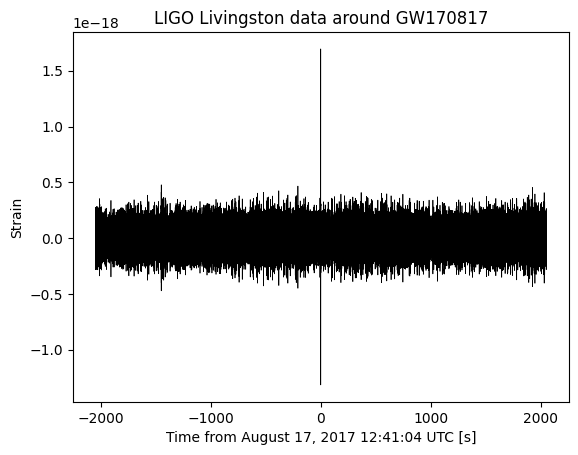

In [3]:
fig, ax = plt.subplots()
ax.plot(gps_time-trigger_time, data, color='black', lw=0.5)
ax.set_xlabel("Time from August 17, 2017 12:41:04 UTC [s]")
ax.set_ylabel("Strain")
ax.set_title("LIGO Livingston data around GW170817")
plt.show()

Working on the assumption that the instrumental noise is (approximately) stationary, we will split the data into multiple short, nonoverlapping segments.
We will use the off-source segments to estimate the noise and then use this analyse the segment containing the signal + glitch.

We split the data into 128 nonoverlapping windows of length 32 seconds.

In [4]:
from WDM.code.noise.periodogram import overlapping_windows

num_perseg = 32*int(f_samp)
num_overlap = 0

windows = overlapping_windows(data, 
                              num_perseg, 
                              num_overlap)

window_times = overlapping_windows(gps_time, 
                                   num_perseg, 
                                   num_overlap)

num_windows = windows.shape[-2]

print(f"Number of windows {num_windows}")

Number of windows 128


The signal is in window number 63. 

We split the data into analysis_data (window 63) and off-source data (all other windows).

In [23]:
idx = np.argmax(np.any(window_times>trigger_time, axis=1))

print(f"Signal is in window {idx:d}")

analysis_data = windows[idx,:]
analysis_times = window_times[idx,:]

mask = np.arange(num_windows) != idx
off_source_data = windows[mask,:]

Signal is in window 63


Let us first process this data in the frequency domain. 

We use a Welch periodogram to estimate the power spectral density (PSD) from the off-source data.
We use a Tukey window that is flat across 95% of its duration.

In [6]:
from scipy.signal.windows import tukey
from scipy.interpolate import interp1d

tukey_window = tukey(num_perseg, alpha=0.05)
psd_freqs = np.fft.rfftfreq(num_perseg, d=1./f_samp) 
norm = 2.0 / f_samp / np.sum(tukey_window**2)
np.abs(np.fft.rfft(tukey_window*windows, axis=-1))**2
psd = norm * np.mean(np.abs(np.fft.rfft(tukey_window*windows, axis=-1))**2, axis=0)

Sn = interp1d(psd_freqs, psd, bounds_error=False, fill_value=np.inf)

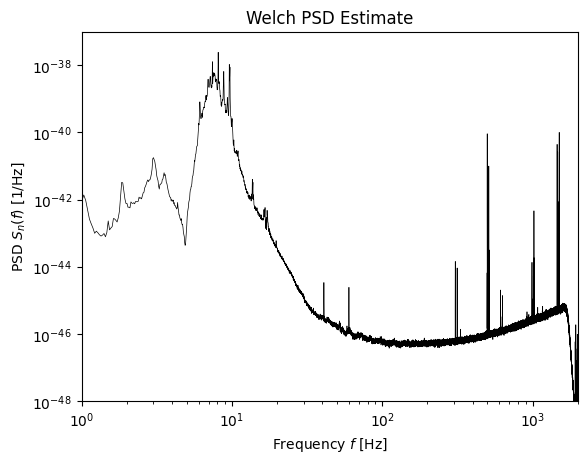

In [7]:
fig, ax = plt.subplots()
ax.loglog(psd_freqs, psd, color='black', lw=0.5)
ax.set_xlim(1, 2000)
ax.set_ylim(1.0e-48, 1.0e-37)
ax.set_xlabel(r'Frequency $f$ [Hz]')
ax.set_ylabel(r'PSD $S_n(f)$ [1/Hz]')
ax.set_title("Welch PSD Estimate")
plt.show()

We can now use this PSD to whitened the analysis data. At the same time we also further bandpass filter the data by setting all frequency components outside the range $10<f<1000$ to zero.

In [8]:
analysis_data_FD = np.fft.rfft(analysis_data) / f_samp

mask = (10.0<psd_freqs) & (psd_freqs <1000.0)
analysis_data_FD[~mask] = 0.0
analysis_data_FD /= np.sqrt(Sn(psd_freqs)*f_samp)

analysis_data_whitened = np.fft.irfft(analysis_data_FD) * f_samp

In the plot of the whitened data you can still only see the glitch. 

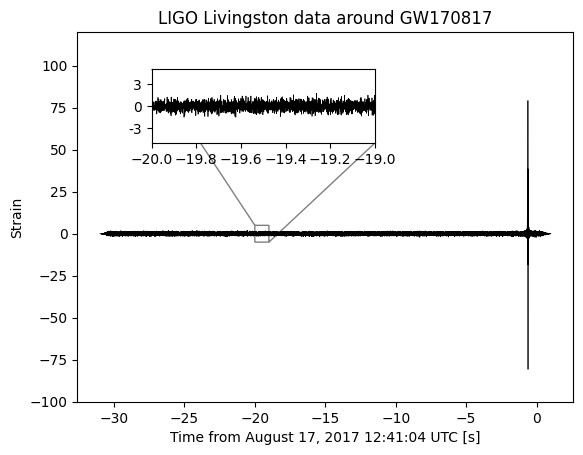

In [9]:
fig, ax = plt.subplots()
ax.plot(analysis_times-trigger_time, analysis_data_whitened*tukey_window, color='black', lw=0.5)
ax.set_xlabel("Time from August 17, 2017 12:41:04 UTC [s]")
ax.set_ylabel("Strain")
ax.set_title("LIGO Livingston data around GW170817")
ax.set_ylim(-100,120)
axins = ax.inset_axes([0.15, 0.7, 0.45, 0.2],
                      xlim=(-20, -19), ylim=(-5, 5), yticks=[-3,0,3], yticklabels=[-3,0,3])
axins.plot(analysis_times-trigger_time, analysis_data_whitened, color='black', lw=0.5)
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.show()

Now let us perform a similar analysis in the time-frequency domain using WDM wavelets.

We will continue to use the 32 long segments of data with the same Tukey window applied.
We will split each segment into $N_f=256$ frequency slices, and $N_t=N/N_f=512$ time slices.

In [10]:
wdm = WDM.WDM.WDM_transform(dt=1./f_samp, Nf=256, N=num_perseg)

t_nm, f_nm = wdm.wavelet_central_time_frequency(np.arange(wdm.Nt), np.arange(wdm.Nf))

print(wdm)

WDM_transform(Nf=256, N=131072, q=16, d=4, A_frac=0.25, calc_m0=False)
self.Nt = 512 time cells
self.Nf = 256 frequency cells
self.dT = 0.0625 time resolution
self.dF = 8.0 frequency resolution
self.K = 8192 window length


We can use the off source data to estimate the covariance matrix of the wavelet coefficients. 
This is analogous to the frequency-domain Welch periodogram.

The noise is assumed to be a Gaussian locally stationary wavelet processes meaning the wavelet coefficients satisfy

$$ \left< w_{nm} w_{n'm'} \right> = C_{(nm)(n'm')} , $$

where 

$$ C_{(nm)(n'm')} = S_{nm} \delta_{nn'} \delta_{mm'} . $$

Note, by performing this averaging we are still assuming that the instrumental noise is stationary. 
If you wanted to go beyond this assumption you would have to introduce some kind of model for the time dependence of the noise and fit this to the data. 
This is not done here.

(Note, the `.dwt` method is vectorised and computes all the discrete wavelet transfroms at once.)

In [21]:
wavelet_covariance = np.mean(np.abs(wdm.dwt(tukey_window*windows))**2, axis=0)

We can visualise this wavelet coefficient covariance matrix in several ways:
 - as a function of frequency; this corresponding to plotting rows of the matrix $S_{nm}$ for several fixed $n$.
 - as a function of time; this corresponding to plotting columns of the matrix $S_{nm}$ for several fixed $m$.
 - as a function of time and frequency; this plots the whole matrix using `imshow`.

These three figures are shown below.

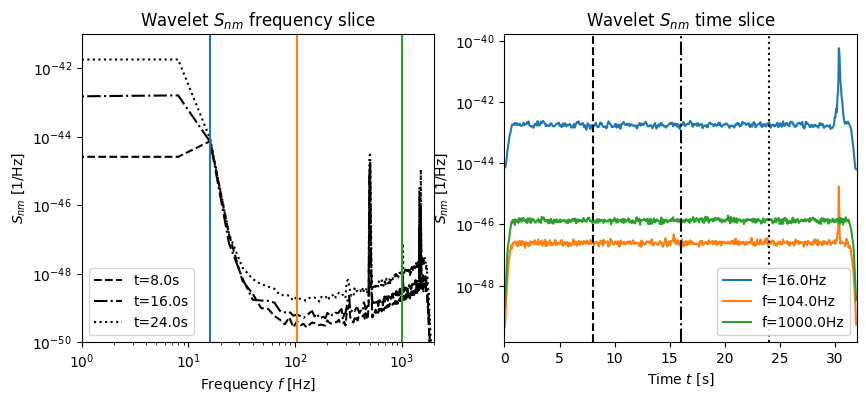

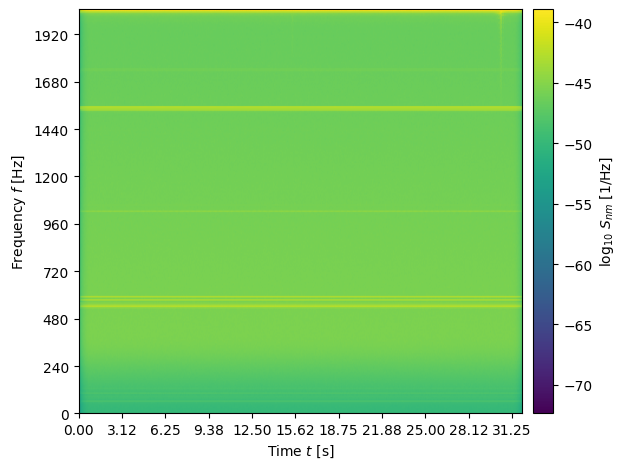

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

for i, t_idx in enumerate([128, 256, 384]):
    axes[0].loglog(f_nm[0,:], wavelet_covariance[i,:].T, 
                   label=f"t={t_nm[t_idx,1]}s", 
                   color='k', ls=['--','-.',':'][i])
for i, f_idx in enumerate([2,13,125]):
    axes[0].axvline(f_nm[1, f_idx], color='C{}'.format(i))
axes[0].set_xlim(1, 2000)
axes[0].set_ylim(1.0e-50, 1.0e-41)
axes[0].set_xlabel(r'Frequency $f$ [Hz]')
axes[0].set_ylabel(r'$S_{nm}$ [1/Hz]')
axes[0].set_title("Wavelet $S_{nm}$ frequency slice")
axes[0].legend(loc='lower left')

for i, f_idx in enumerate([2,13,125]):
    axes[1].plot(t_nm[:,1], wavelet_covariance[:,f_idx].T,
                        label=f"f={f_nm[1,f_idx]}Hz", 
                        color='C{}'.format(i))
for i, t_idx in enumerate([128, 256, 384]):
    axes[1].axvline(t_nm[t_idx,1], color='k', ls=['--','-.',':'][i])
axes[1].set_xlim(0, 32)
axes[1].set_yscale('log')
axes[1].set_xlabel(r'Time $t$ [s]')
axes[1].set_ylabel(r'$S_{nm}$ [1/Hz]')
axes[1].set_title("Wavelet $S_{nm}$ time slice")
axes[1].legend(loc='lower right', framealpha=0.9)

plt.show()

fig, ax = plt.subplots()
im = ax.imshow(np.log10(wavelet_covariance.T), extent=[0., num_perseg/f_samp, 0., 0.5*f_samp], aspect='auto')
cbar = fig.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(r'$\log_{10}\, S_{nm}$ [1/Hz]')
ax.set_xticks(t_nm[::50,1])
ax.set_yticks(f_nm[1,::30])
ax.set_xlabel(r'Time $t$ [s]')
ax.set_ylabel(r'Frequency $f$ [Hz]')
plt.tight_layout()
plt.show()

Now we can take the wavelet transform of the analysis data. We can plot these coefficients using `imshow` to get a visual time-frequency representation of the signal.

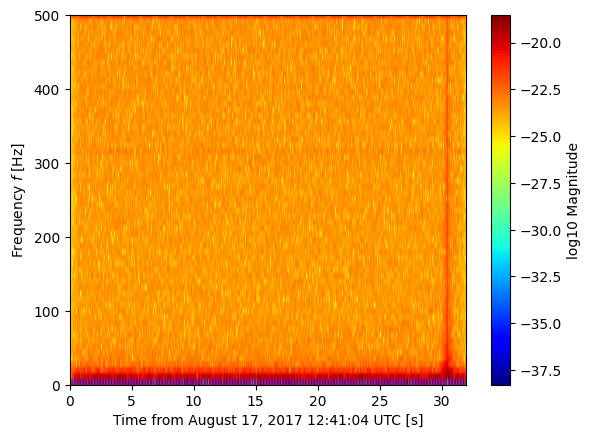

In [13]:
from WDM.code.plotting.plotting import time_frequency_plot

wavelet_w = wdm.dwt(analysis_data*tukey_window)

fig, ax = time_frequency_plot(wdm, wavelet_w, part='abs', scale='log')
ax.set_xlabel("Time from August 17, 2017 12:41:04 UTC [s]")
ax.set_ylabel(r'Frequency $f$ [Hz]')
ax.set_ylim(0, 500)
plt.show()

Now that we have inferred the wavelet coefficient covariance matrix from the off-source data, we can use this to analyse the analysis data.

We define the wavelet-whitened time series as 

$$ \hat{x}(t) = \sum_n\sum_n\frac{w_{nm}}{\sqrt{S_{nm}}}g_{nm}(t) .$$

As well as whitening we can also perform bandpass filtering an glitch removal. 
We will set to zero all the wavelet coefficients $w_{nm}$ whose frequencies are not in the range $20<f_{nm}/\mathrm{Hz}<1000$.
And we will set to zero all the wavelet coefficients $w_{nm}$ whose times are in the range $29.8<t_{nm}/\mathrm{s}<30.9$.

In [14]:
wavelet_w_whitened = wavelet_w / np.sqrt(wavelet_covariance)

In [15]:
bandpass = (f_nm>20) & (f_nm<1000)
wavelet_w_whitened_bandpassfiltered = np.zeros_like(wavelet_w)
wavelet_w_whitened_bandpassfiltered[bandpass] = wavelet_w_whitened[bandpass]

In [16]:
deglitch = (t_nm<29.8) | (t_nm>30.9)
wavelet_w_whitened_bandpassfiltered_deglitched = np.zeros_like(wavelet_w)
wavelet_w_whitened_bandpassfiltered_deglitched[deglitch] = wavelet_w_whitened_bandpassfiltered[deglitch]

In this representation of the data the chirping time-frequency track of the GW signal can be seen.

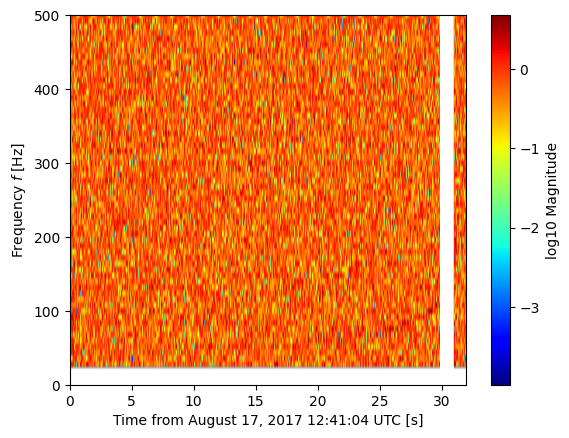

In [17]:
fig, ax = time_frequency_plot(wdm, wavelet_w_whitened_bandpassfiltered_deglitched, part='abs', scale='log')
ax.set_xlabel("Time from August 17, 2017 12:41:04 UTC [s]")
ax.set_ylabel(r'Frequency $f$ [Hz]')
ax.set_ylim(0, 500)
plt.show()

We can now transform this wavelet-whitened, filtered and deglitched analysis data back into the time domain.

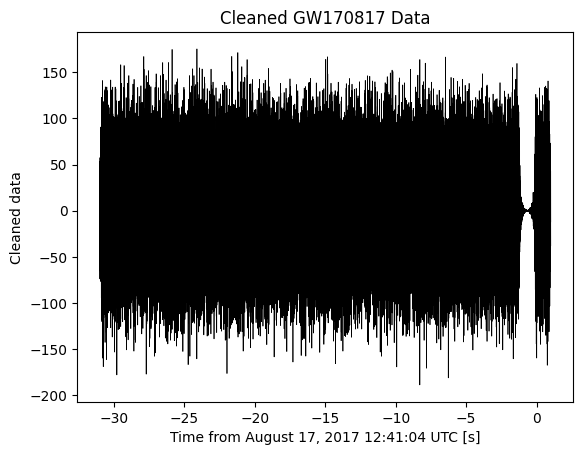

In [18]:
clean_data = wdm.idwt(wavelet_w_whitened_bandpassfiltered_deglitched)

fig, ax = plt.subplots()
ax.plot(analysis_times-trigger_time, clean_data, color='black', lw=0.5)
ax.set_xlabel("Time from August 17, 2017 12:41:04 UTC [s]")
ax.set_ylabel("Cleaned data")
ax.set_title("Cleaned GW170817 Data")
plt.show()